## lenstronomy starting guide

In [1]:
# some standard python imports #
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

### Single plane lensing

In [2]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SPEP', 'SHEAR']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_spep = {'theta_E': 1.1, 'e1': 0.05, 'e2': 0.05, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}
kwargs_lens = [kwargs_spep, kwargs_shear]


# image plane coordinate #
theta_ra, theta_dec = .9, .4

# source plane coordinate #
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
# Fermat potential #
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, 
                                        kwargs_lens=kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

### Multi-plane lensing

In [3]:
# keep the imports and variables from above #
# specify redshifts of deflectors #
redshift_list = [0.5, 0.5, .1]
# specify source redshift #
z_source = 1.5
# setup lens model class with the list of lens models #
lens_model_list_mp = ['SPEP', 'SHEAR', 'SIS']
lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

kwargs_sis = {'theta_E': 0.1, 'center_x': 1., 'center_y': -0.1}
kwargs_lens_mp = [kwargs_spep, kwargs_shear, kwargs_sis]

# source plane coordinate #
beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens_mp)

# Magnification #
mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens_mp)

# arrival time relative to a straight path through (0,0) #
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens_mp)

### lens equation solver

In [4]:
# keep the imports and variables from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

/home/emma-hoggett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


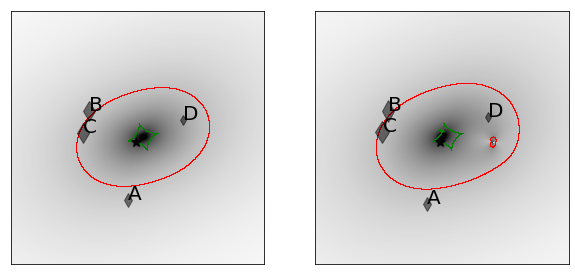

In [18]:
from lenstronomy.Plots import lens_plot
f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens_mp, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True)
f.show()

In [10]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel
# set up the list of light models to be used #
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
# define the parameters #
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# evaluate surface brightness at a specific position #
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

In [11]:
# import the PointSource class #
from lenstronomy.PointSource.point_source import PointSource

# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

In [12]:

# import the PixelGrid() class #
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

## *ImSim* Solution

### Simulate image

/home/emma-hoggett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


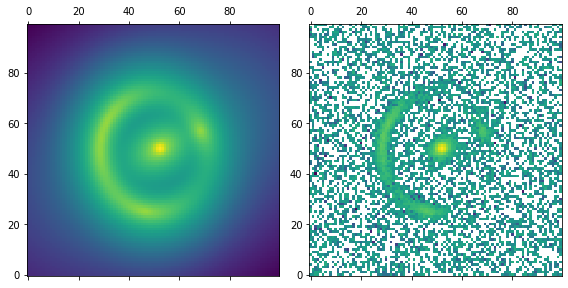

In [14]:

# import the ImageModel class #
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
plt.show()

### Linear inversion

In [15]:
from lenstronomy.Data.imaging_data import ImageData
# update the data with the noisy image and its noise properties #
kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

data_class = ImageData(**kwargs_data)

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
image_linear_fit = ImageLinearFit(data_class=data_class, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)

# we do not require the knowledge of the linear parameters #
del kwargs_light_source[0]['amp']
# apply the linear inversion to fit for the noisy image #
image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, 
                              kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

-0.9880264732678578 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9880264732678578


/home/emma-hoggett/.local/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:88: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


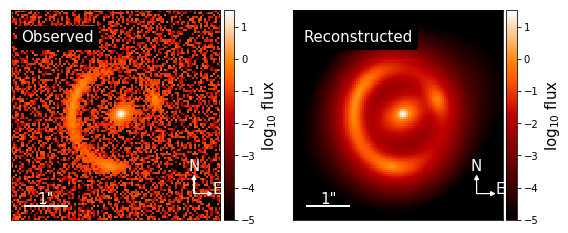

In [17]:

# illustrate fit #
from lenstronomy.Plots.model_plot import ModelPlot
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_light_model_list,
               'lens_light_model_list': lens_light_model_list} #, 'point_source_model_list': point_source_model_list}
kwargs_params = {'kwargs_lens': kwargs_lens, 'kwargs_source': kwargs_light_source,
                 'kwargs_lens_light': kwargs_light_lens, 'kwargs_ps': kwargs_ps}
lensPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_params, arrow_size=0.02)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
lensPlot.data_plot(ax=axes[0])
lensPlot.model_plot(ax=axes[1])
f.tight_layout()
plt.show()